In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded==files.upload();

NameError: ignored

In [ ]:
%cd /content/drive/MyDrive/inception-score-pytorch

/content/drive/MyDrive/inception-score-pytorch


In [ ]:
calcu=[0.9923322,0.99030954,0.9899182,0.989791,0.9897412,0.9895359,0.98942417,0.9887033,0.9885682,0.98839545,0.9882703,0.9880314,0.98737246,0.9871867,0.9869846,0.9868624,0.9867577,0.98644847,0.98594356,0.9859212]
sum=0.0
for x in calcu:
  sum=sum+x
print(sum/20)

0.9883248974999999


1.15.5
2032
Instructions for updating:
Use tf.gfile.GFile.
0.9671116
0.5469416
0.24693005
0.3762977
0.6158575
0.7430407
0.62722844
0.9329989
0.68711525
0.5329681
0.44331843
0.73619103
0.3016128
0.3760519
0.5724161
0.57395226
0.6895023
0.15679824
0.6666615
0.46004087
0.2996061
0.9256873
0.80594236
0.6963664
0.486105
0.2410834
0.49496105
0.41593853
0.87644947
0.21362697
0.3544371
0.94385153
0.8287538
0.45505
0.24117015
0.5310752
0.35417932
0.23414008
0.9868624
0.9083644
0.6034962
0.23513547
0.25338772
0.17099929
0.15147056
0.5502718
0.93388677
0.5081441
0.82552093
0.69955826
0.29823145
0.39938715
0.35144994
0.7555793
0.40824053
0.57118386
0.7829483
0.1430411
0.64561373
0.73579633
0.4860038
0.28876477
0.33515662
0.33594453
0.34358683
0.26214004
0.20974211
0.5901814
0.5338613
0.87727416
0.49627367
0.28518742
0.18719386
0.48890042
0.9577295
0.13690886
0.47928375
0.6635415
0.62329954
0.717864
0.33144212
0.31541893
0.8562774
0.59334713
0.81833875
0.22859904
0.14995225
0.47061685
0.4833893
0.4

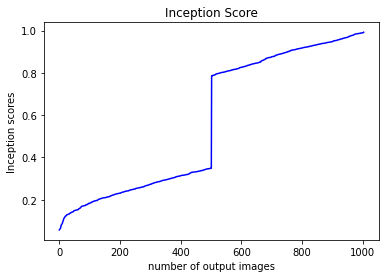

In [ ]:
########################################################################
#
# The Inception Model v3 for TensorFlow.
#
# This is a pre-trained Deep Neural Network for classifying images.
# You provide an image or filename for a jpeg-file which will be
# loaded and input to the Inception model, which will then output
# an array of numbers indicating how likely it is that the
# input-image is of each class.
#
# See the example code at the bottom of this file or in the
# accompanying Python Notebooks.
#
# Tutorial #07 shows how to use the Inception model.
# Tutorial #08 shows how to use it for Transfer Learning.
#
# What is Transfer Learning?
#
# Transfer Learning is the use of a Neural Network for classifying
# images from another data-set than it was trained on. For example,
# the Inception model was trained on the ImageNet data-set using
# a very powerful and expensive computer. But the Inception model
# can be re-used on data-sets it was not trained on without having
# to re-train the entire model, even though the number of classes
# are different for the two data-sets. This allows you to use the
# Inception model on your own data-sets without the need for a
# very powerful and expensive computer to train it.
#
# The last layer of the Inception model before the softmax-classifier
# is called the Transfer Layer because the output of that layer will
# be used as the input in your new softmax-classifier (or as the
# input for another neural network), which will then be trained on
# your own data-set.
#
# The output values of the Transfer Layer are called Transfer Values.
# These are the actual values that will be input to your new
# softmax-classifier or to another neural network that you create.
#
# The word 'bottleneck' is also sometimes used to refer to the
# Transfer Layer or Transfer Values, but it is a confusing word
# that is not used here.
#
# Implemented in Python 3.5 with TensorFlow v0.10.0rc0
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################
import torch
import torch.nn.functional as F
import math
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import download
from cache import Cache
import os
import sys
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow

########################################################################
# Various directories and file-names.

# Internet URL for the tar-file with the Inception model.
# Note that this might change in the future and will need to be updated.
data_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"

# Directory to store the downloaded data.
data_dir = "/content/drive/MyDrive/inception-score-pytorch/tryon/"

# File containing the mappings between class-number and uid. (Downloaded)
path_uid_to_cls = "imagenet_2012_challenge_label_map_proto.pbtxt"

# File containing the mappings between uid and string. (Downloaded)
path_uid_to_name = "imagenet_synset_to_human_label_map.txt"

# File containing the TensorFlow graph definition. (Downloaded)
path_graph_def = "classify_image_graph_def.pb"

########################################################################


def maybe_download():
    """
    Download the Inception model from the internet if it does not already
    exist in the data_dir. The file is about 85 MB.
    """

    print("Downloading Inception v3 Model ...")
    download.maybe_download_and_extract(url=data_url, download_dir=data_dir)


########################################################################


class NameLookup:
    """
    Used for looking up the name associated with a class-number.
    This is used to print the name of a class instead of its number,
    e.g. "plant" or "horse".

    Maps between:
    - cls is the class-number as an integer between 1 and 1000 (inclusive).
    - uid is a class-id as a string from the ImageNet data-set, e.g. "n00017222".
    - name is the class-name as a string, e.g. "plant, flora, plant life"

    There are actually 1008 output classes of the Inception model
    but there are only 1000 named classes in these mapping-files.
    The remaining 8 output classes of the model should not be used.
    """

    def __init__(self):
        # Mappings between uid, cls and name are dicts, where insertions and
        # lookup have O(1) time-usage on average, but may be O(n) in worst case.
        self._uid_to_cls = {}   # Map from uid to cls.
        self._uid_to_name = {}  # Map from uid to name.
        self._cls_to_uid = {}   # Map from cls to uid.

        # Read the uid-to-name mappings from file.
        path = os.path.join(data_dir, path_uid_to_name)
        with open(file=path, mode='r') as file:
            # Read all lines from the file.
            lines = file.readlines()

            for line in lines:
                # Remove newlines.
                line = line.replace("\n", "")

                # Split the line on tabs.
                elements = line.split("\t")

                # Get the uid.
                uid = elements[0]

                # Get the class-name.
                name = elements[1]

                # Insert into the lookup-dict.
                self._uid_to_name[uid] = name

        # Read the uid-to-cls mappings from file.
        path = os.path.join(data_dir, path_uid_to_cls)
        with open(file=path, mode='r') as file:
            # Read all lines from the file.
            lines = file.readlines()

            for line in lines:
                # We assume the file is in the proper format,
                # so the following lines come in pairs. Other lines are ignored.

                if line.startswith("  target_class: "):
                    # This line must be the class-number as an integer.

                    # Split the line.
                    elements = line.split(": ")

                    # Get the class-number as an integer.
                    cls = int(elements[1])

                elif line.startswith("  target_class_string: "):
                    # This line must be the uid as a string.

                    # Split the line.
                    elements = line.split(": ")

                    # Get the uid as a string e.g. "n01494475"
                    uid = elements[1]

                    # Remove the enclosing "" from the string.
                    uid = uid[1:-2]

                    # Insert into the lookup-dicts for both ways between uid and cls.
                    self._uid_to_cls[uid] = cls
                    self._cls_to_uid[cls] = uid

    def uid_to_cls(self, uid):
        """
        Return the class-number as an integer for the given uid-string.
        """

        return self._uid_to_cls[uid]

    def uid_to_name(self, uid, only_first_name=False):
        """
        Return the class-name for the given uid string.

        Some class-names are lists of names, if you only want the first name,
        then set only_first_name=True.
        """

        # Lookup the name from the uid.
        name = self._uid_to_name[uid]

        # Only use the first name in the list?
        if only_first_name:
            name = name.split(",")[0]

        return name

    def cls_to_name(self, cls, only_first_name=False):
        """
        Return the class-name from the integer class-number.

        Some class-names are lists of names, if you only want the first name,
        then set only_first_name=True.
        """

        # Lookup the uid from the cls.
        uid = self._cls_to_uid[cls]

        # Lookup the name from the uid.
        name = self.uid_to_name(uid=uid, only_first_name=only_first_name)

        return name


########################################################################


class Inception:
    """
    The Inception model is a Deep Neural Network which has already been
    trained for classifying images into 1000 different categories.

    When you create a new instance of this class, the Inception model
    will be loaded and can be used immediately without training.

    The Inception model can also be used for Transfer Learning.
    """

    # Name of the tensor for feeding the input image as jpeg.
    tensor_name_input_jpeg = "DecodeJpeg/contents:0"

    # Name of the tensor for feeding the decoded input image.
    # Use this for feeding images in other formats than jpeg.
    tensor_name_input_image = "DecodeJpeg:0"

    # Name of the tensor for the resized input image.
    # This is used to retrieve the image after it has been resized.
    tensor_name_resized_image = "ResizeBilinear:0"

    # Name of the tensor for the output of the softmax-classifier.
    # This is used for classifying images with the Inception model.
    tensor_name_softmax = "softmax:0"

    # Name of the tensor for the unscaled outputs of the softmax-classifier (aka. logits).
    tensor_name_softmax_logits = "softmax/logits:0"

    # Name of the tensor for the output of the Inception model.
    # This is used for Transfer Learning.
    tensor_name_transfer_layer = "pool_3:0"

    def __init__(self):
        # Mappings between class-numbers and class-names.
        # Used to print the class-name as a string e.g. "horse" or "plant".
        self.name_lookup = NameLookup()

        # Now load the Inception model from file. The way TensorFlow
        # does this is confusing and requires several steps.

        # Create a new TensorFlow computational graph.
        self.graph = tf.Graph()

        # Set the new graph as the default.
        with self.graph.as_default():

            # TensorFlow graphs are saved to disk as so-called Protocol Buffers
            # aka. proto-bufs which is a file-format that works on multiple
            # platforms. In this case it is saved as a binary file.

            # Open the graph-def file for binary reading.
            path = os.path.join(data_dir, path_graph_def)
            with tf.io.gfile.GFile(path,'rb') as file:
                # The graph-def is a saved copy of a TensorFlow graph.
                # First we need to create an empty graph-def.
                graph_def = tf.compat.v1.GraphDef()

                # Then we load the proto-buf file into the graph-def.
                graph_def.ParseFromString(file.read())

                # Finally we import the graph-def to the default TensorFlow graph.
                tf.import_graph_def(graph_def, name='')

                # Now self.graph holds the Inception model from the proto-buf file.

        # Get the output of the Inception model by looking up the tensor
        # with the appropriate name for the output of the softmax-classifier.
        self.y_pred = self.graph.get_tensor_by_name(self.tensor_name_softmax)

        # Get the unscaled outputs for the Inception model (aka. softmax-logits).
        self.y_logits = self.graph.get_tensor_by_name(self.tensor_name_softmax_logits)

        # Get the tensor for the resized image that is input to the neural network.
        self.resized_image = self.graph.get_tensor_by_name(self.tensor_name_resized_image)

        # Get the tensor for the last layer of the graph, aka. the transfer-layer.
        self.transfer_layer = self.graph.get_tensor_by_name(self.tensor_name_transfer_layer)

        # Get the number of elements in the transfer-layer.
        self.transfer_len = self.transfer_layer.get_shape()[3]

        # Create a TensorFlow session for executing the graph.
        self.session = tf.Session(graph=self.graph)

    def close(self):
        """
        Call this function when you are done using the Inception model.
        It closes the TensorFlow session to release its resources.
        """

        self.session.close()

    def _write_summary(self, logdir='summary/'):
        """
        Write graph to summary-file so it can be shown in TensorBoard.

        This function is used for debugging and may be changed or removed in the future.

        :param logdir:
            Directory for writing the summary-files.

        :return:
            Nothing.
        """

        writer = tf.train.SummaryWriter(logdir=logdir, graph=self.graph)
        writer.close()

    def _create_feed_dict(self, image_path=None, image=None):
        """
        Create and return a feed-dict with an image.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            Dict for feeding to the Inception graph in TensorFlow.
        """

        if image is not None:
            # Image is passed in as a 3-dim array that is already decoded.
            feed_dict = {self.tensor_name_input_image: image}

        elif image_path is not None:
            # Read the jpeg-image as an array of bytes.
            image_data = tf.gfile.FastGFile(image_path, 'rb').read()

            # Image is passed in as a jpeg-encoded image.
            feed_dict = {self.tensor_name_input_jpeg: image_data}

        else:
            raise ValueError("Either image or image_path must be set.")

        return feed_dict

    def classify(self, image_path=None, image=None):
        """
        Use the Inception model to classify a single image.

        The image will be resized automatically to 299 x 299 pixels,
        see the discussion in the Python Notebook for Tutorial #07.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            Array of floats (aka. softmax-array) indicating how likely
            the Inception model thinks the image is of each given class.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Execute the TensorFlow session to get the predicted labels.
        pred = self.session.run(self.y_pred, feed_dict=feed_dict)

        # Reduce the array to a single dimension.
        pred = np.squeeze(pred)

        return pred

    def get_resized_image(self, image_path=None, image=None):
        """
        Input an image to the Inception model and return
        the resized image. The resized image can be plotted so
        we can see what the neural network sees as its input.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            A 3-dim array holding the image.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Execute the TensorFlow session to get the predicted labels.
        resized_image = self.session.run(self.resized_image, feed_dict=feed_dict)

        # Remove the 1st dimension of the 4-dim tensor.
        resized_image = resized_image.squeeze(axis=0)

        # Scale pixels to be between 0.0 and 1.0
        resized_image = resized_image.astype(float) / 255.0

        return resized_image

    def print_scores(self, pred, k=10, only_first_name=True):
        """
        Print the scores (or probabilities) for the top-k predicted classes.

        :param pred:
            Predicted class-labels returned from the predict() function.

        :param k:
            How many classes to print.

        :param only_first_name:
            Some class-names are lists of names, if you only want the first name,
            then set only_first_name=True.

        :return:
            Nothing.
        """

        # Get a sorted index for the pred-array.
        idx = pred.argsort()

        # The index is sorted lowest-to-highest values. Take the last k.
        top_k = idx[-k:]

        # Iterate the top-k classes in reversed order (i.e. highest first).
        for cls in reversed(top_k):
            # Lookup the class-name.
            name = self.name_lookup.cls_to_name(cls=cls, only_first_name=only_first_name)

            # Predicted score (or probability) for this class.
            score = pred[cls]

            return score

            # print(score)

            # # Print the score and class-name.
            # print("{0:>6.2%} : {1}".format(score, name))

    def transfer_values(self, image_path=None, image=None):
        """
        Calculate the transfer-values for the given image.
        These are the values of the last layer of the Inception model before
        the softmax-layer, when inputting the image to the Inception model.

        The transfer-values allow us to use the Inception model in so-called
        Transfer Learning for other data-sets and different classifications.

        It may take several hours or more to calculate the transfer-values
        for all images in a data-set. It is therefore useful to cache the
        results using the function transfer_values_cache() below.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            The transfer-values for those images.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Use TensorFlow to run the graph for the Inception model.
        # This calculates the values for the last layer of the Inception model
        # prior to the softmax-classification, which we call transfer-values.
        transfer_values = self.session.run(self.transfer_layer, feed_dict=feed_dict)

        # Reduce to a 1-dim array.
        transfer_values = np.squeeze(transfer_values)

        return transfer_values


########################################################################
# Batch-processing.


def process_images(fn, images=None, image_paths=None):
    """
    Call the function fn() for each image, e.g. transfer_values() from
    the Inception model above. All the results are concatenated and returned.

    :param fn:
        Function to be called for each image.

    :param images:
        List of images to process.

    :param image_paths:
        List of file-paths for the images to process.

    :return:
        Numpy array with the results.
    """

    # Are we using images or image_paths?
    using_images = images is not None

    # Number of images.
    if using_images:
        num_images = len(images)
    else:
        num_images = len(image_paths)

    # Pre-allocate list for the results.
    # This holds references to other arrays. Initially the references are None.
    result = [None] * num_images

    # For each input image.
    for i in range(num_images):
        # Status-message. Note the \r which means the line should overwrite itself.
        msg = "\r- Processing image: {0:>6} / {1}".format(i+1, num_images)

        # Print the status message.
        sys.stdout.write(msg)
        sys.stdout.flush()

        # Process the image and store the result for later use.
        if using_images:
            result[i] = fn(image=images[i])
        else:
            result[i] = fn(image_path=image_paths[i])

    # Print newline.
    print()

    # Convert the result to a numpy array.
    result = np.array(result)

    return result


########################################################################


def transfer_values_cache(cache_path, model, images=None, image_paths=None):
    """
    This function either loads the transfer-values if they have
    already been calculated, otherwise it calculates the values
    and saves them to a file that can be re-loaded again later.

    Because the transfer-values can be expensive to compute, it can
    be useful to cache the values through this function instead
    of calling transfer_values() directly on the Inception model.

    See Tutorial #08 for an example on how to use this function.

    :param cache_path:
        File containing the cached transfer-values for the images.

    :param model:
        Instance of the Inception model.

    :param images:
        4-dim array with images. [image_number, height, width, colour_channel]

    :param image_paths:
        Array of file-paths for images (must be jpeg-format).

    :return:
        The transfer-values from the Inception model for those images.
    """

    # Helper-function for processing the images if the cache-file does not exist.
    # This is needed because we cannot supply both fn=process_images
    # and fn=model.transfer_values to the cache()-function.
    def fn():
        return process_images(fn=model.transfer_values, images=images, image_paths=image_paths)

    # Read the transfer-values from a cache-file, or calculate them if the file does not exist.
    transfer_values = cache(cache_path=cache_path, fn=fn)

    return transfer_values

load_images = lambda x: np.asarray(Image.open(x).resize((480, 640)))

# display imgs
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (400, 400))
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)


########################################################################
# Example usage.

from pathlib import Path
import matplotlib.pyplot as plt
from os import path

if __name__ == '__main__':
    print(tf.__version__)

    # Download Inception model if not already done.
    # maybe_download()
    # array
    
    files = []
    path = Path('/content/drive/MyDrive/inception-score-pytorch/tryon')

    for file in path.iterdir():
      file = str(file)
      if(file[-3:]=='jpg'):
       files.append(file[-12:])

    no_files=len(files)
    print(no_files)

    # Load the Inception model so it is ready for classifying images.
    model = Inception()
    all_scores=[]
    # _img1=''
    # maxres=0.0
    # sum=0.0
    for x in files:
      # Path for a jpeg-image that is included in the downloaded data.
      image_path = os.path.join(data_dir,x)

      # Use the Inception model to classify the image.
      pred = model.classify(image_path=image_path)

      # Print the scores and names for the top-10 predictions.
      
      score=model.print_scores(pred=pred, k=1)
      all_scores.append(score)
      # sum=sum+score
      # if score > maxres:
      #   maxres=score
      #   _img1=x
      print(score)
    
    all_scores.sort()
    new_score=[]

    for i in range(0,502):
      new_score.append(all_scores[i])

    for i in range(1530,no_files):
      new_score.append(all_scores[i])

    
    # saved_score=all_scores
    # localStorage.setItem("quentinTarantino", JSON.stringify(saved_score));

    sum=0.0
    for x in new_score:
      sum=sum+x

    mean=sum/(len(new_score))

    total_sum=0.0
    for x in new_score:
      val=((x-mean)*(x-mean))
      total_sum=total_sum+val

    S_D=total_sum/(len(new_score))
    S_D=S_D**0.5
    print("standard deviation is :")
    print(S_D)
    print("Mean is :")
    print(mean)

    
    x = np.array(new_score)
    plt.title("Inception Score")
    plt.plot(x, color="blue")
    plt.xlabel('number of output images')
    plt.ylabel('Inception scores')

    plt.show()

    # print("maximum Inception score is")
    # print(maxres)
    # print("image with maximum inception score")
    # print(_img1)
    # display_imgs(load_images("/content/drive/MyDrive/inception-score-pytorch/tryon/"+_img1))
    # Close the TensorFlow session.
    model.close()

    # Transfer Learning is demonstrated in Tutorial #08.

########################################################################

In [ ]:
!pip install tensorflow==1.15.5

     |████████████████████████████████| 110.5 MB 1.3 kB/s 
     |████████████████████████████████| 2.9 MB 40.7 MB/s 
     |████████████████████████████████| 3.8 MB 47.6 MB/s 
     |████████████████████████████████| 503 kB 55.9 MB/s 
     |████████████████████████████████| 50 kB 4.8 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=0f563209554252b001313590e3d101998b9b70cde5156341cb243bf1f6024a39
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tens

In [ ]:
import pygraphviz

def build_graph(root):
    # https://pygraphviz.github.io/documentation/latest/tutorial.html
    G = pygraphviz.AGraph(strict=True, directed=True)

    # http://www.graphviz.org/content/attrs#dordering
    G.graph_attr["rankdir"] = "TB"
    #G.graph_attr["splines"] = "ortho"
    G.graph_attr["splines"] = "curved"
    #G.graph_attr["size"] = "10,3"
    G.graph_attr["ordering"] = "out"
    G.layout(prog='dot')

    # http://stackoverflow.com/questions/279561/what-is-the-python-equivalent-of-static-variables-inside-a-function
    def _id(node, _static={"seq":0}):
        if node: return id(node)
        _static["seq"] += 1
        return "_%d" % _static["seq"]

    def graphviz_customize(node):
        return {
            "label": node.val if node else "#",
            "shape": "box" if node else "oval",
            "color": "blue", # if node else "black",
            "fontsize": 8,
            "width": 0.05 if node else 0.02, # in inches
            "height": 0.02 if node else 0.02,
        }

    # mimic the serialiation
    if not root:
        id_root = _id(root)
        G.add_node(id_root, **graphviz_customize(root))
        return G

    wq = deque([(root, _id(root), "", 0)])
    count = 1
    while count and wq:
        node, id_node, id_parent, right_child = wq.popleft()

        G.add_node(id_node, **graphviz_customize(node))
        if id_parent:
            if right_child:
                G.add_edge(id_parent, id_node, color='black', style='dashed')
            else:
                G.add_edge(id_parent, id_node, color='red', style='dashed')

        if not node: continue

        count -= 1
        for idx, nd in enumerate((node.left, node.right)):
            if nd:
                count += 1
            wq.append((nd, _id(nd), id_node, idx))

    return G

from io import BytesIO
from IPython.display import Image, display

def display_graph(G):
    # https://github.com/chebee7i/nxpd/blob/master/nxpd/ipythonsupport.py
    imgbuf = BytesIO()
    G.draw(imgbuf, format='png', prog='dot')
    img = Image(imgbuf.getvalue())
    display(img)

## main ##
root = deserialize('[2,1,3,0,7,9,1,2,null,1,0,null,null,8,8,null,null,null,null,7]')
G = build_graph(root)
display_graph(G)

ModuleNotFoundError: ignored

In [ ]:
!sudo apt-get install graphviz libgraphviz-dev pkg-config python-pip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
libgraphviz-dev is already the newest version (2.40.1-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libpython-all-dev python-all python-all-dev python-asn1crypto
  python-cffi-backend python-crypto python-cryptography python-dbus
  python-enum34 python-gi python-idna python-ipaddress python-keyring
  python-keyrings.alt python-pip-whl python-pkg-resources python-secretstorage
  python-setuptools python-six python-wheel python-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python-cryptography-vectors
  python-dbus-dbg python-dbus-doc python-enum34-doc python-gi-cairo
  gnome-keyring l

In [ ]:
!pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz/" 

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
  Using cached pygraphviz-1.7.zip (118 kB)
Skipping wheel build for pygraphviz, due to binaries being disabled for it.
    Running setup.py install for pygraphviz ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-m0bfvcnn/pygraphviz_44aa0bc952434d4ba55b6b7a4834e8a4/setup.py'"'"'; __file__='"'"'/tmp/pip-install-m0bfvcnn/pygraphviz_44aa0bc952434d4ba55b6b7a4834e8a4/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --reco